### Part 2.a.

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

ds = fetch_openml ('mnist_784', as_frame = False )

c:\Users\royin\anaconda3\envs\pytorch-tlio\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame({'Images':list(ds.data), 'Target': ds.target})

In [3]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [5]:
train_idx = []
val_idx = []
for category in df.Target.unique():
    train_idx += df[df.Target==category].sample(1000).index.to_list()
    val_idx += df[((~(df.index.isin(train_idx)))&(df.Target==category))].sample(100).index.to_list()
train_df = df[df.index.isin(train_idx)]
val_df = df[df.index.isin(val_idx)]
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
print(train_df.shape, val_df.shape)
train_df.Target.value_counts(), val_df.Target.value_counts()

(10000, 2) (1000, 2)


(Target
 1    1000
 7    1000
 0    1000
 9    1000
 6    1000
 4    1000
 2    1000
 3    1000
 8    1000
 5    1000
 Name: count, dtype: int64,
 Target
 8    100
 4    100
 5    100
 9    100
 0    100
 1    100
 3    100
 7    100
 6    100
 2    100
 Name: count, dtype: int64)

In [12]:
train_df['Final_Img'] = train_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())
val_df['Final_Img'] = val_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())
x = np.stack(train_df.Final_Img)
y = train_df.Target
x_test = np.stack(val_df.Final_Img)
y_test = val_df.Target
train_df.shape, x.shape, y.shape, val_df.shape, x_test.shape, y_test.shape

C:\Users\royin\AppData\Local\Temp\ipykernel_33540\3971047577.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Final_Img'] = train_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())
C:\Users\royin\AppData\Local\Temp\ipykernel_33540\3971047577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Final_Img'] = val_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())


((10000, 3), (10000, 196), (10000,), (1000, 3), (1000, 196), (1000,))

In [13]:
x = np.where(x>128, 1, 0)
x_test = np.where(x_test>128, 1, 0)
x.shape, x_test.shape

((10000, 196), (1000, 196))

### Part 2.b

In [34]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [63]:
class AutoEncoder(nn.Module):

    

    def __init__(self):
        super().__init__()



        self.encoder = nn.Sequential(
            nn.Linear(196, 128),
            nn.Tanh(),
            nn.Linear(128,16))
        self.decoder = nn.Sequential(
            nn.Linear(8, 128),
            nn.Tanh(),
            nn.Linear(128, 196),
            nn.Sigmoid()
        )



    def forward_enc(self, x):
        return self.encoder(x)
    
    def forward_dec(self, x):
        return self.decoder(x)

In [79]:
loss_ce = nn.BCELoss(reduction='sum')

In [80]:
test_sample = torch.ones((2,3))
torch.sum(test_sample, 1).shape

torch.Size([2])

In [81]:
batch_size = 32
x[np.random.choice(10000,9984)].reshape((-1, batch_size, x.shape[1])).shape

(312, 32, 196)

In [93]:
def custom_criterion(encoder_output, decoder_output1, decoder_output2, image):
    target = torch.concat([image, image], 0)
    output = torch.concat([decoder_output1, decoder_output2], 0)
    loss_term1 = F.binary_cross_entropy(output, target, reduction='sum')/(2*batch_size)
    log_var = encoder_output[:,8:]
    mu = encoder_output[:,:8]
    loss_term2 = -(1/2) * torch.sum((torch.ones((batch_size, 8)).to(device) + log_var - mu**2 - torch.exp(log_var)), 1).reshape((-1,1))
    loss_term2 = torch.sum(loss_term2)/batch_size
    total_loss = loss_term1 + loss_term2
    return loss_term1, loss_term2, total_loss

In [121]:
ae_net = AutoEncoder().to(device)
epochs = 50
optimizer = torch.optim.Adam(ae_net.parameters(), lr=0.001) #, weight_decay=0.0001

In [122]:
## training loop
def train(net, optimizer, x_train, x_test, epochs):
    model = net.to(device)
    total_step = len(x_train)
    loss_term1_list = []
    loss_term2_list = []
    total_loss_list = []
    lr = 0.001
    # print(schedule_lr)
    for epoch in range(epochs):
        for i in range(total_step):
            input_x = x_train[i].to(device)
            encoder_output = model.forward_enc(input_x)
            decoder_input1 = encoder_output[:,:8] + torch.exp(0.5*encoder_output[:,8:]) * torch.randn_like(encoder_output[:,8:])
            decoder_input2 = encoder_output[:,:8] + torch.exp(0.5*encoder_output[:,8:]) * torch.randn_like(encoder_output[:,8:])
            decoder_output1 = model.forward_dec(decoder_input1)
            decoder_output2 = model.forward_dec(decoder_input2)
            
            loss_term1, loss_term2, total_loss = custom_criterion(encoder_output, decoder_output1, decoder_output2, input_x)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            loss_term1_list.append(loss_term1.item())
            loss_term2_list.append(loss_term2.item())
            total_loss_list.append(total_loss.item())
         
            print ('Epoch [{}/{}], Loss_term1: {:.4f}, Loss_term2: {:.4f}, Total_loss: {:.4f}'.format(epoch, epochs, loss_term1, loss_term2, total_loss))

        if epoch%20 ==0 and epoch!=0:
            lr = 0.1 * lr
            for op_params in optimizer.param_groups:
                op_params['lr'] = lr

        
    return loss_term1_list, loss_term2_list, total_loss_list

In [55]:
x_train = torch.Tensor(x[np.random.choice(10000,9984)]).reshape((-1, batch_size, x.shape[1]))
x_test = torch.Tensor(x_test[np.random.choice(1000,31*32)]).reshape((-1, batch_size, x_test.shape[1]))

(31, 32, 196)

In [123]:
loss_term1_list, loss_term2_list, total_loss_list = train(ae_net, optimizer, x_train, x_test, epochs)

Epoch [0/50], Loss_term1: 137.6712, Loss_term2: 0.0888, Total_loss: 137.7600
Epoch [0/50], Loss_term1: 136.0542, Loss_term2: 0.1270, Total_loss: 136.1812
Epoch [0/50], Loss_term1: 134.7504, Loss_term2: 0.1383, Total_loss: 134.8886
Epoch [0/50], Loss_term1: 133.5675, Loss_term2: 0.1800, Total_loss: 133.7475
Epoch [0/50], Loss_term1: 131.7692, Loss_term2: 0.2086, Total_loss: 131.9778
Epoch [0/50], Loss_term1: 130.1859, Loss_term2: 0.2716, Total_loss: 130.4575
Epoch [0/50], Loss_term1: 128.3838, Loss_term2: 0.3273, Total_loss: 128.7111
Epoch [0/50], Loss_term1: 127.3101, Loss_term2: 0.4460, Total_loss: 127.7561
Epoch [0/50], Loss_term1: 123.6351, Loss_term2: 0.5908, Total_loss: 124.2259
Epoch [0/50], Loss_term1: 122.2452, Loss_term2: 0.7556, Total_loss: 123.0008
Epoch [0/50], Loss_term1: 121.1447, Loss_term2: 1.0245, Total_loss: 122.1692
Epoch [0/50], Loss_term1: 116.7926, Loss_term2: 1.2241, Total_loss: 118.0167
Epoch [0/50], Loss_term1: 114.3712, Loss_term2: 1.3081, Total_loss: 115.6793

### Part 2.c

In [124]:
np.min(np.array(total_loss_list))

27.962928771972656

In [125]:
np.save('hw5_p2_total_loss.npy', np.array(total_loss_list))
np.save('hw5_p2_loss_term1.npy', np.array(loss_term1_list))
np.save('hw5_p2_loss_term2.npy', np.array(loss_term2_list))
torch.save(ae_net, 'model1_50epoch_hw5_p2.pt')

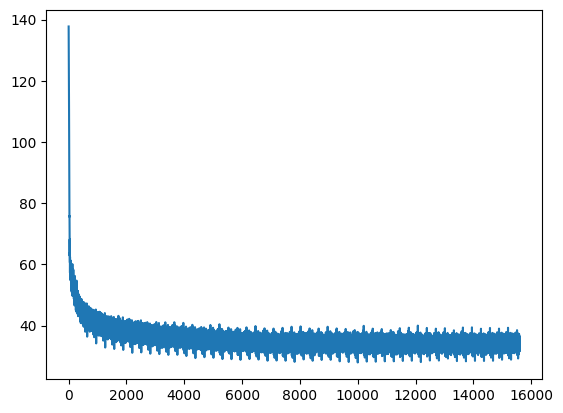

In [126]:
import matplotlib.pyplot as plt
plt.plot(np.array(total_loss_list))

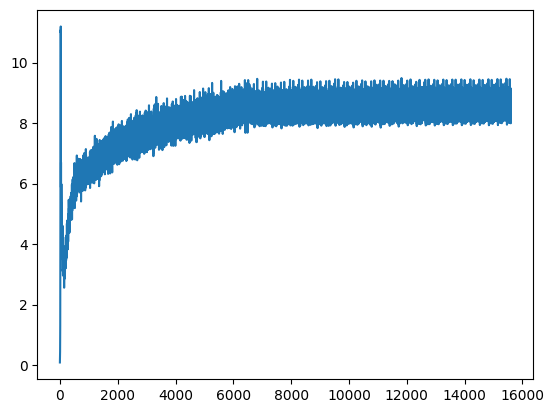

In [127]:
plt.plot(np.array(loss_term2_list))

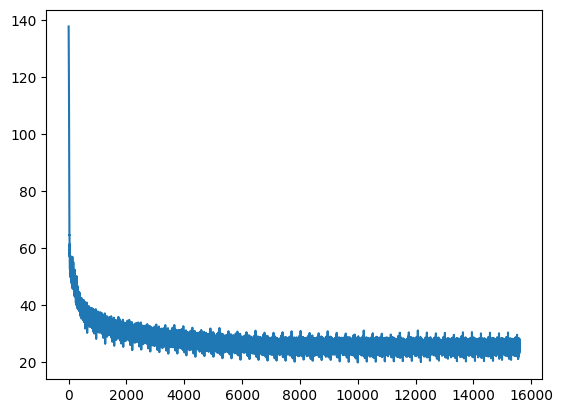

In [128]:
plt.plot(np.array(loss_term1_list))

### Part 2.d

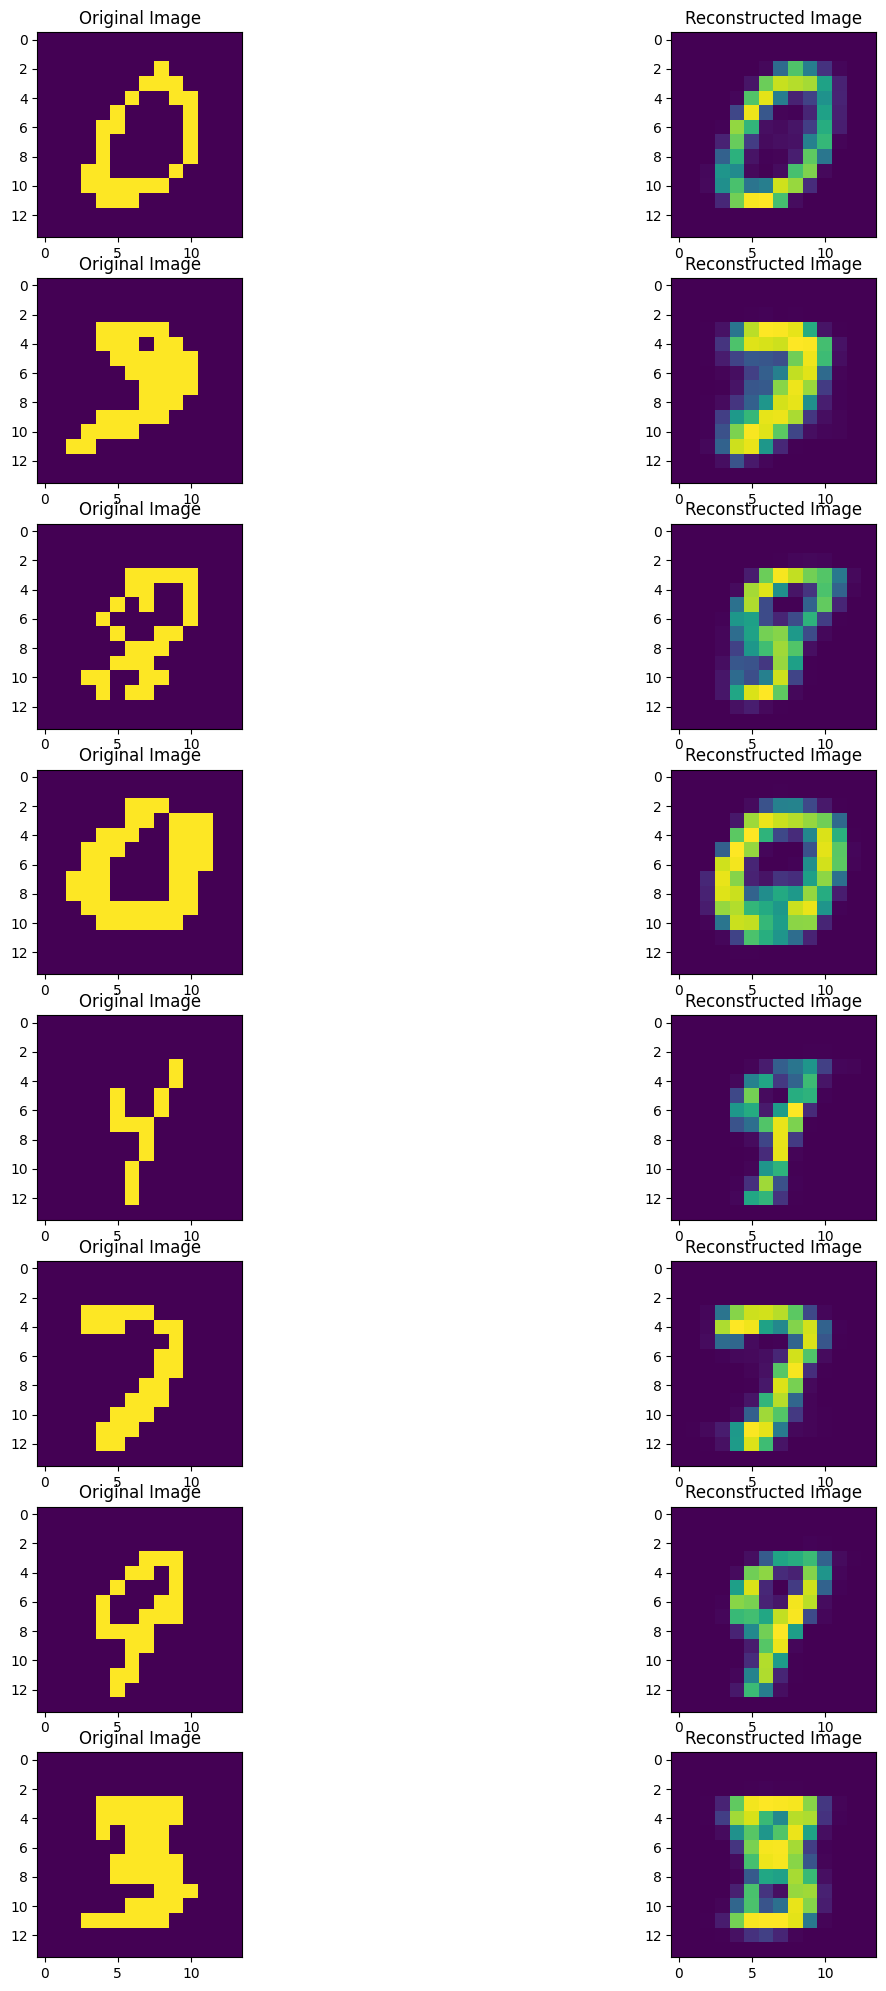

In [142]:
fig, axes = plt.subplots(8, 2, figsize=(15, 25))
labels = ["Reconstructed Image", "Original Image"]
ae_net.eval()
with torch.no_grad():
    for img_idx in range(8):
        index = np.random.choice(31)
        img = torch.Tensor(x_test[img_idx,1,:]).to(device)
        model = ae_net.to(device)
        enc_output = model.forward_enc(img)
        dec_input = enc_output[:8] + torch.exp(0.5*enc_output[8:])
        output = model.forward_dec(dec_input)
        plt.subplot(8,2,(img_idx*2+ 0)+1)
        plt.imshow(img.detach().cpu().reshape((14,14)))
        plt.title(labels[1])
        plt.subplot(8,2,(img_idx*2+1)+1)
        plt.imshow(output.detach().cpu().reshape((14,14)))
        plt.title(labels[0])
    plt.show()


### Part 2.e.

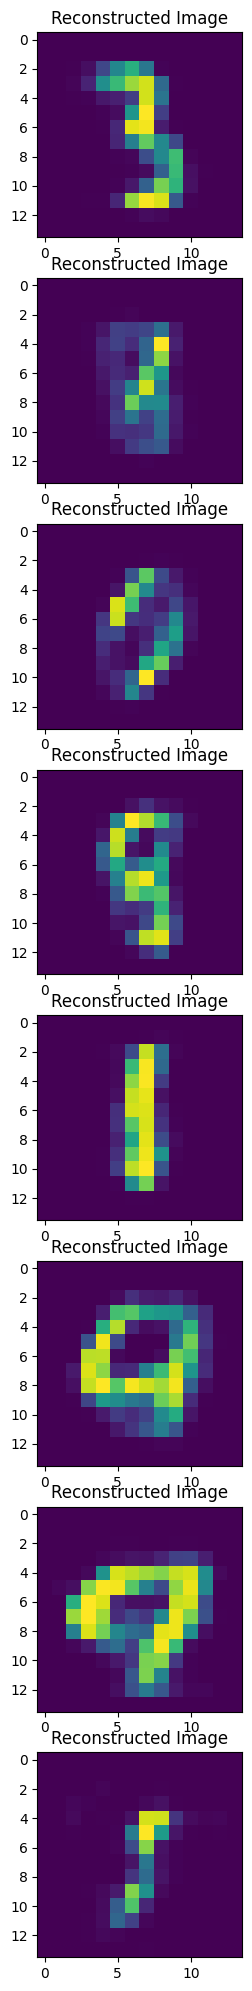

In [148]:
fig, axes = plt.subplots(8,1, figsize=(10, 25))
labels = ["Reconstructed Image"]
ae_net.eval()
with torch.no_grad():
    for img_idx in range(8):
        noise = torch.randn((1,8)).to(device)
        model = ae_net.to(device)
        output = model.forward_dec(noise)
        plt.subplot(8,1, img_idx+1)
        plt.imshow(output.detach().cpu().reshape((14,14)))
        plt.title(labels[0])
        
    plt.show()


### Part 2.f

In [161]:
## training loop
def train(net, optimizer, x_train, x_test, epochs):
    model = net.to(device)
    total_step = len(x_train)
    running_loss_term1_list = []
    val_loss_term1_list = []
    running_val_loss_term1 = 0
    lr = 0.001
    # print(schedule_lr)
    for epoch in range(epochs):
        for i in range(total_step):
            iteration = epoch * total_step + i
            input_x = torch.Tensor(x_train[i]).to(device)
            encoder_output = model.forward_enc(input_x)
            decoder_input1 = encoder_output[:,:8] + torch.exp(0.5*encoder_output[:,8:]) * torch.randn_like(encoder_output[:,8:])
            decoder_input2 = encoder_output[:,:8] + torch.exp(0.5*encoder_output[:,8:]) * torch.randn_like(encoder_output[:,8:])
            decoder_output1 = model.forward_dec(decoder_input1)
            decoder_output2 = model.forward_dec(decoder_input2)
            
            loss_term1, loss_term2, total_loss = custom_criterion(encoder_output, decoder_output1, decoder_output2, input_x)
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            running_loss_term1_list.append(loss_term1.item())
            # running_term1_loss += loss_term1.item()
            
            if iteration%100 == 0:
            #     if iteration==0:
            #         running_loss_term1_list.append(running_term1_loss)
            #     else:
            #         running_term1_loss /= 100
            #         running_loss_term1_list.append(running_term1_loss)
            #         print ('Epoch [{}/{}], Loss_term1: {:.4f}'.format(epoch, epochs, running_term1_loss))
            #         running_term1_loss = 0
                model.eval()
                with torch.no_grad():
                    print('Validation results:')
                    for val_i in range(len(x_test)):
                        input_x = torch.Tensor(x_test[val_i]).to(device)
                        encoder_output = model.forward_enc(input_x)
                        decoder_input = encoder_output[:,:8] + torch.exp(0.5*encoder_output[:,8:])
                        decoder_output1 = model.forward_dec(decoder_input)
                        val_loss_term1 = F.binary_cross_entropy(decoder_output1, input_x, reduction='sum')/batch_size
                        running_val_loss_term1 += val_loss_term1.item()
                    running_val_loss_term1 /= len(x_test)
                    val_loss_term1_list.append(running_val_loss_term1)
                    print ('Val Loss_term1: {:.4f}'.format(running_val_loss_term1))
                    running_val_loss_term1 = 0
         
           

        if epoch%20 ==0 and epoch!=0:
            lr = 0.1 * lr
            for op_params in optimizer.param_groups:
                op_params['lr'] = lr

        
    return running_loss_term1_list, val_loss_term1_list

In [162]:
ae_net = AutoEncoder().to(device)
epochs = 50
optimizer = torch.optim.Adam(ae_net.parameters(), lr=0.001) #, weight_decay=0.0001
running_loss_term1_list, val_loss_term1_list = train(ae_net, optimizer, x_train, x_test, epochs)

Validation results:
Val Loss_term1: 138.5367
Validation results:
Val Loss_term1: 51.7889
Validation results:
Val Loss_term1: 46.1895
Validation results:
Val Loss_term1: 41.2989
Validation results:
Val Loss_term1: 37.8313
Validation results:
Val Loss_term1: 36.7126
Validation results:
Val Loss_term1: 36.7181
Validation results:
Val Loss_term1: 35.9908
Validation results:
Val Loss_term1: 35.7436
Validation results:
Val Loss_term1: 34.3360
Validation results:
Val Loss_term1: 33.9568
Validation results:
Val Loss_term1: 33.3547
Validation results:
Val Loss_term1: 33.1521
Validation results:
Val Loss_term1: 32.8517
Validation results:
Val Loss_term1: 32.0843
Validation results:
Val Loss_term1: 32.4010
Validation results:
Val Loss_term1: 31.9987
Validation results:
Val Loss_term1: 31.9664
Validation results:
Val Loss_term1: 31.8167
Validation results:
Val Loss_term1: 31.8260
Validation results:
Val Loss_term1: 31.6330
Validation results:
Val Loss_term1: 31.3221
Validation results:
Val Loss_te

In [163]:
np.save('hw5_p2_running_loss_term1_list.npy', np.array(running_loss_term1_list))
np.save('hw5_p2_val_loss_term1_list.npy', np.array(val_loss_term1_list))
torch.save(ae_net, 'model1_50epoch_hw5_p2f.pt')

[]

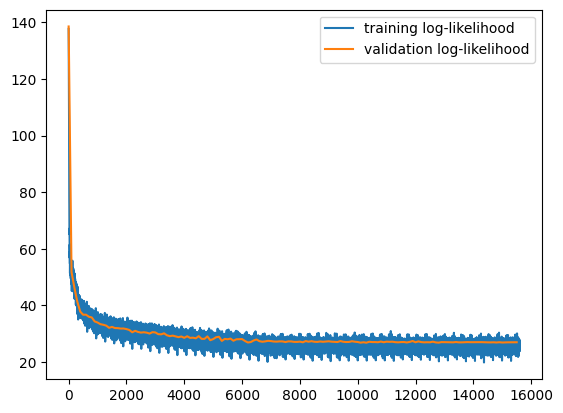

In [164]:
plt.plot(np.arange(len(running_loss_term1_list)), np.array(running_loss_term1_list), label = 'training log-likelihood')
plt.plot(100*np.arange(len(val_loss_term1_list)), np.array(val_loss_term1_list), label = 'validation log-likelihood')
plt.legend()
plt.plot()